In [8]:
import os

data_dir = "/content/lens_data"


print("Folders in dataset:", os.listdir(data_dir))


Folders in dataset: ['train_nonlenses', '__MACOSX', 'train_lenses', 'test_lenses', 'test_nonlenses']


In [9]:
def count_images(directory):
    return len(os.listdir(directory))

lens_count = count_images(os.path.join(data_dir, "train_lenses"))
nonlens_count = count_images(os.path.join(data_dir, "train_nonlenses"))

print(f"Train Lenses: {lens_count}, Train Non-Lenses: {nonlens_count}")

test_lens_count = count_images(os.path.join(data_dir, "test_lenses"))
test_nonlens_count = count_images(os.path.join(data_dir, "test_nonlenses"))

print(f"Test Lenses: {test_lens_count}, Test Non-Lenses: {test_nonlens_count}")


Train Lenses: 1730, Train Non-Lenses: 28675
Test Lenses: 195, Test Non-Lenses: 19455


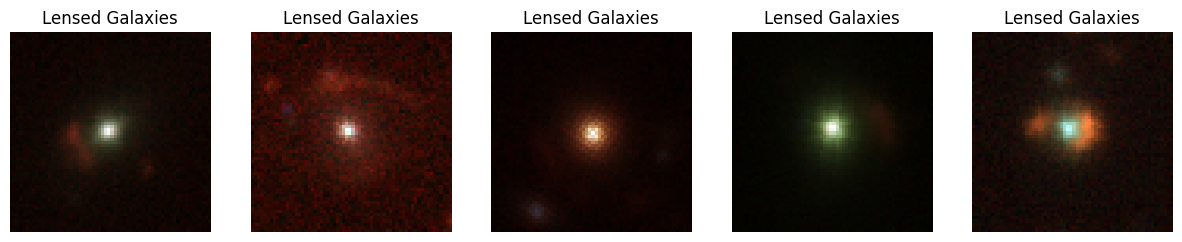

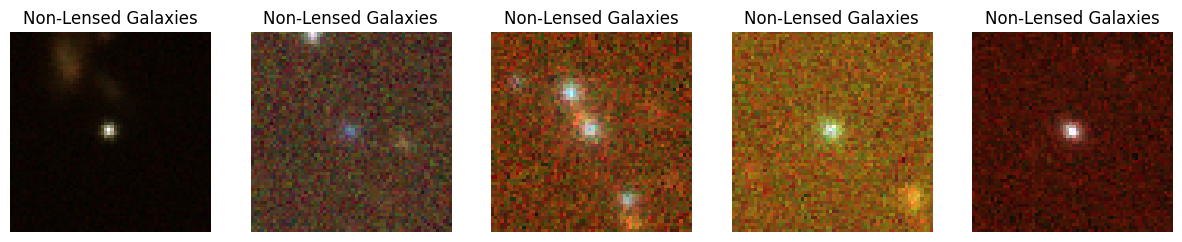

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to load and display sample .npy images
def show_sample_npy_images(folder, title, num_images=5):
    images = [f for f in os.listdir(folder) if f.endswith('.npy')][:num_images]  # Filter .npy files
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = np.load(img_path)  # Load .npy file

        # Rearrange dimensions from (3, 64, 64) -> (64, 64, 3) for proper visualization
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(title)

    plt.show()

# Show images from each class
show_sample_npy_images(os.path.join(data_dir, "train_lenses"), "Lensed Galaxies")
show_sample_npy_images(os.path.join(data_dir, "train_nonlenses"), "Non-Lensed Galaxies")


In [49]:
import torch
from torch.utils.data import Dataset, random_split
import numpy as np
import os


class LensDataset(Dataset):
    def __init__(self, lens_dir, nonlens_dir, transform=None):
        self.lens_images = [os.path.join(lens_dir, f) for f in os.listdir(lens_dir) if f.endswith('.npy')]
        self.nonlens_images = [os.path.join(nonlens_dir, f) for f in os.listdir(nonlens_dir) if f.endswith('.npy')]
        self.transform = transform


        self.data = [(img, 1) for img in self.lens_images] + [(img, 0) for img in self.nonlens_images]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = np.load(img_path)
        img = torch.tensor(img, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)


lens_path = os.path.join(data_dir, "train_lenses")
nonlens_path = os.path.join(data_dir, "train_nonlenses")


full_dataset = LensDataset(lens_path, nonlens_path)


train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 27364, Test samples: 3041


In [50]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(64),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [51]:
from torch.utils.data import DataLoader, WeightedRandomSampler


num_lenses = sum(1 for _, label in train_dataset if label == 1)
num_nonlenses = sum(1 for _, label in train_dataset if label == 0)

class_counts = [num_lenses, num_nonlenses]
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)


weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset), replacement=True)


train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("DataLoaders ready")


DataLoaders ready


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

class LensNet(nn.Module):
    def __init__(self):
        super(LensNet, self).__init__()


        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)


        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 2)


        self.relu = nn.ReLU()


        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        x = self.relu(self.conv2(x))
        x = self.maxpool(x)

        x = self.relu(self.conv3(x))
        x = self.maxpool(x)


        x = x.view(x.size(0), -1)


        x = self.relu(self.fc1(x))
        x = self.dropout(x)


        x = self.fc2(x)

        return x


In [53]:
import torch
import torch.optim as optim
import torch.nn as nn


model = LensNet().cuda()


criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)



In [54]:

def save_checkpoint(epoch, model, optimizer, loss, filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}.")

def load_checkpoint(filename='checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from epoch {epoch}.")
    return epoch, loss


In [55]:

num_epochs = 100
best_val_loss = float('inf')
start_epoch = 0



for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()


        outputs = model(inputs)
        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()


        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        running_loss += loss.item()


    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total


    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()


            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)


    val_loss /= len(test_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint(epoch, model, optimizer, val_loss)


Epoch [1/100], Train Loss: 0.0345, Train Accuracy: 99.47%, Val Loss: 0.2319, Val Accuracy: 94.74%
Checkpoint saved at epoch 0.
Epoch [2/100], Train Loss: 0.0263, Train Accuracy: 99.64%, Val Loss: 0.3805, Val Accuracy: 94.74%
Epoch [3/100], Train Loss: 0.0265, Train Accuracy: 99.65%, Val Loss: 0.3867, Val Accuracy: 94.74%
Epoch [4/100], Train Loss: 0.0252, Train Accuracy: 99.66%, Val Loss: 0.2878, Val Accuracy: 94.74%
Epoch [5/100], Train Loss: 0.0242, Train Accuracy: 99.66%, Val Loss: 0.3068, Val Accuracy: 94.74%
Epoch [6/100], Train Loss: 0.0244, Train Accuracy: 99.65%, Val Loss: 0.3201, Val Accuracy: 94.74%
Epoch [7/100], Train Loss: 0.0260, Train Accuracy: 99.63%, Val Loss: 0.3495, Val Accuracy: 94.74%
Epoch [8/100], Train Loss: 0.0286, Train Accuracy: 99.59%, Val Loss: 0.3202, Val Accuracy: 94.74%
Epoch [9/100], Train Loss: 0.0284, Train Accuracy: 99.58%, Val Loss: 0.2237, Val Accuracy: 94.74%
Checkpoint saved at epoch 8.
Epoch [10/100], Train Loss: 0.0289, Train Accuracy: 99.58%, 

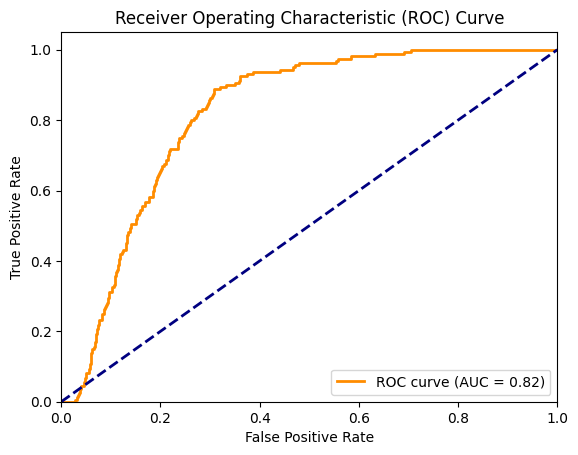

AUC Score: 0.82


In [57]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch

# Set the model to evaluation mode for testing
model.eval()

# Collect true labels and predicted probabilities
true_labels = []
pred_probs = []

with torch.no_grad():  # Don't compute gradients during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        # Forward pass
        outputs = model(inputs)

        # Get probabilities (softmax)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for "lensed" class (class 1)

        true_labels.extend(labels.cpu().numpy())  # True labels (0 or 1)
        pred_probs.extend(probs.cpu().numpy())  # Predicted probabilities for the "lensed" class

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print the AUC score
print(f"AUC Score: {roc_auc:.2f}")
